In [ ]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

from mplsoccer import Pitch, VerticalPitch





def load_competitions(sb_data_root: Path) -> pd.DataFrame:
    comp_path = sb_data_root / "competitions.json"
    comps = json.loads(comp_path.read_text(encoding="utf-8"))
    return pd.DataFrame(comps)

TARGET = [
    ("England", "Premier League"),
  #  ("Spain", "La Liga"),
  #  ("Italy", "Serie A"),
  #  ("Germany", "1. Bundesliga"),
]

def pick_competitions_1516(comps):
    selected = []

    for country, comp in TARGET:
        sel = comps[
            (comps["country_name"] == country) &
            (comps["competition_name"] == comp) &
            (comps["season_name"] == "2015/2016")
        ]

        if sel.empty:
            raise ValueError(f"Missing: {country} {comp} 2015/2016")

        selected.append(sel.iloc[0])

    return pd.DataFrame(selected)


def load_matches(sb_data_root: Path, competition_id: int, season_id: int) -> pd.DataFrame:
    p = sb_data_root / "matches" / str(competition_id) / f"{season_id}.json"
    matches = json.loads(p.read_text(encoding="utf-8"))
    return pd.DataFrame(matches)

def _safe_id(x):
    if isinstance(x, dict) and "id" in x: return x["id"]
    return np.nan

def _safe_name(x):
    if isinstance(x, dict) and "name" in x: return x["name"]
    return None

def flatten_events_for_match(sb_data_root: Path, match_row: dict) -> pd.DataFrame:
    match_id = match_row["match_id"]
    p = sb_data_root / "events" / f"{match_id}.json"
    ev = json.loads(p.read_text(encoding="utf-8"))

    rows = []
    for e in ev:
        loc = e.get("location", None)
        x = loc[0] if isinstance(loc, list) and len(loc) >= 2 else np.nan
        y = loc[1] if isinstance(loc, list) and len(loc) >= 2 else np.nan

        # end locations (pass/carry)
        endx = endy = np.nan
        pass_length = np.nan
        pass_subtype = None

        if "pass" in e and e["pass"] is not None:
            end = e["pass"].get("end_location", None)
            if isinstance(end, list) and len(end) >= 2:
                endx, endy = end[0], end[1]
            pass_length = e["pass"].get("length", np.nan)
            pass_subtype = _safe_name(e["pass"].get("type"))
        elif "carry" in e and e["carry"] is not None:
            end = e["carry"].get("end_location", None)
            if isinstance(end, list) and len(end) >= 2:
                endx, endy = end[0], end[1]

        rows.append({
            "match_id": match_id,
            "competition_id": match_row["competition"]["competition_id"] if isinstance(match_row.get("competition"), dict) else match_row.get("competition_id"),
            "season_id": match_row["season"]["season_id"] if isinstance(match_row.get("season"), dict) else match_row.get("season_id"),
            "competition_name": match_row.get("competition", {}).get("competition_name", None) if isinstance(match_row.get("competition"), dict) else None,
            "season_name": match_row.get("season", {}).get("season_name", None) if isinstance(match_row.get("season"), dict) else None,

            "type": _safe_name(e.get("type")),
            "play_pattern": _safe_name(e.get("play_pattern")),
            "team_id": _safe_id(e.get("team")),
            "team_name": _safe_name(e.get("team")),
            "possession": e.get("possession", np.nan),
            "possession_team_id": _safe_id(e.get("possession_team")),
            "possession_team_name": _safe_name(e.get("possession_team")),

            "minute": e.get("minute", np.nan),
            "second": e.get("second", np.nan),
            "timestamp": e.get("timestamp", None),  
            "duration": e.get("duration", np.nan),  
            "period" : e.get("period", np.nan),

            "x": x, "y": y,
            "endx": endx, "endy": endy,

            "pass_length": pass_length,
            "pass_subtype": pass_subtype,
        })

    return pd.DataFrame(rows)

def load_all_events_1516(sb_data_root: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    comps = load_competitions(sb_data_root)
    picked = pick_competitions_1516(comps)

    all_matches = []
    for _, r in picked.iterrows():
        m = load_matches(sb_data_root, int(r["competition_id"]), int(r["season_id"]))
        # enrich for convenience
        m["competition_name"] = r["competition_name"]
        m["season_name"] = r["season_name"]
        all_matches.append(m)

    matches_df = pd.concat(all_matches, ignore_index=True)

    # Load events
    event_dfs = []
    for _, mr in matches_df.iterrows():
        event_dfs.append(flatten_events_for_match(sb_data_root, mr.to_dict()))

    events_df = pd.concat(event_dfs, ignore_index=True)

    # create a "league" label that matches your normalization bucket
    events_df["league_season"] = events_df["competition_name"].fillna("") + " | " + events_df["season_name"].fillna("")
    matches_df["league_season"] = matches_df["competition_name"].fillna("") + " | " + matches_df["season_name"].fillna("")

    return comps, matches_df, events_df


In [24]:
from functions import (
    calc_width, calc_directness, calc_tempo,
    calc_pressing_height, calc_pressing_intensity,
    calc_pass_length, get_progressive_actions, calc_possession_time
)
from tqdm import tqdm

def build_team_match_features_1516(sb_data_root: Path) -> pd.DataFrame:
    comps = load_competitions(sb_data_root)
    picked = pick_competitions_1516(comps)

    all_feature_rows = []

    for _, r in picked.iterrows():

        matches = load_matches(
            sb_data_root,
            int(r["competition_id"]),
            int(r["season_id"])
        )

        league_label = r["competition_name"] + " | " + r["season_name"]

        for _, match in tqdm(
            matches.iterrows(),
            total=len(matches),
            desc=f"{league_label}",
            leave=False
        ):
            events = flatten_events_for_match(sb_data_root, match.to_dict())

            actions = get_progressive_actions(events)

            f_width = calc_width(actions, match=True)
            f_dir   = calc_directness(actions, match=True)
            f_tempo = calc_tempo(events, match=True)
            f_ph    = calc_pressing_height(events)
            f_pi    = calc_pressing_intensity(events)
            f_pl    = calc_pass_length(events, match=True)

            merged = (
                f_width
                .merge(f_dir, on=["match_id","team_id"], how="outer")
                .merge(f_tempo, on=["match_id","team_id"], how="outer")
                .merge(f_ph, on=["match_id","team_id"], how="outer")
                .merge(f_pi, on=["match_id","team_id"], how="outer")
                .merge(f_pl, on=["match_id","team_id"], how="outer")
            )
            team_map = events[["team_id", "team_name"]].drop_duplicates()
            merged = merged.merge(team_map, on="team_id", how="left")

            merged["league_season"] = league_label
            all_feature_rows.append(merged)

            # free memory
            del events, actions, f_width, f_dir, f_tempo, f_ph, f_pi, f_pl, merged

    return pd.concat(all_feature_rows, ignore_index=True)



In [25]:
def team_season_agg(team_match_df: pd.DataFrame, events_df: pd.DataFrame) -> pd.DataFrame:
    # attach league_season + team_name
    meta = events_df[["match_id","team_id","team_name","league_season"]].drop_duplicates()
    tm = team_match_df.merge(meta, on=["match_id","team_id"], how="left")

    # aggregate over matches → team-season profile
    # (mean is fine for intent; you can also add std later)
    group_cols = ["league_season", "team_id", "team_name"]
    feature_cols = [c for c in tm.columns if c not in set(group_cols + ["match_id"])]

    team_season = tm.groupby(group_cols)[feature_cols].mean(numeric_only=True).reset_index()
    return team_season
def attach_league_meta(team_match_df, events_df):
    meta = (
        events_df[["match_id","team_id","team_name","league_season"]]
        .drop_duplicates()
    )
    return team_match_df.merge(meta, on=["match_id","team_id"], how="left")

def zscore_within_league_season(team_season_df: pd.DataFrame) -> pd.DataFrame: #For full season
    df = team_season_df.copy()
    id_cols = ["league_season", "team_id", "team_name"]
    feat_cols = [c for c in df.columns if c not in id_cols]

    def zgrp(g):
        mu = g[feat_cols].mean()
        sd = g[feat_cols].std(ddof=0).replace(0, np.nan)
        gz = (g[feat_cols] - mu) / sd
        g_out = g[id_cols].copy()
        for c in feat_cols:
            g_out[c] = gz[c]
        return g_out

    return df.groupby("league_season", group_keys=False).apply(zgrp).reset_index(drop=True)

def zscore_match_within_league(team_match_df: pd.DataFrame) -> pd.DataFrame: #Per mathc level
    df = team_match_df.copy()

    id_cols = ["league_season","match_id","team_id","team_name"]
    feat_cols = [c for c in df.columns if c not in id_cols]

    def zgrp(g):
        mu = g[feat_cols].mean()
        sd = g[feat_cols].std(ddof=0).replace(0, np.nan)

        gz = (g[feat_cols] - mu) / sd

        g_out = g[id_cols].copy()
        for c in feat_cols:
            g_out[c] = gz[c]

        return g_out

    return (
        df.groupby("league_season", group_keys=False)
          .apply(zgrp)
          .reset_index(drop=True)
    )



In [26]:
from pathlib import Path
import os
DATA_ROOT = Path(os.environ["EXJOBB_DATA"])
sb_root = DATA_ROOT / "open-data-master" / "data"
matches_dir = sb_root / "matches"
events_dir  = sb_root / "events"
three_dir   = sb_root / "three-sixty"
comps = pd.read_json(sb_root / "competitions.json")
team_match = build_team_match_features_1516(sb_root)   # NEW memory-safe builder

# team-season aggregation (no events_df needed)
feature_cols = [c for c in team_match.columns if c not in ["league_season","team_id","team_name","match_id"]]

team_season = (
    team_match
    .groupby(["league_season","team_id","team_name"], as_index=False)[feature_cols]
    .mean(numeric_only=True)
)




#team_season_z = zscore_within_league_season(team_season)

#team_season_z.to_csv("team_season_intent_1516_z.csv", index=False)
#print("Saved: team_season_intent_1516_z.csv")


Premier League | 2015/2016:   0%|          | 0/380 [00:00<?, ?it/s]/Users/stefanivchenko/code/exjobb/functions.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype("Int64")
/Users/stefanivchenko/code/exjobb/functions.py:343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pass_width"] = abs(df["endy"] - 40)
Premier League | 2015/2016:   0%|          | 1/380 [00:00<00:48,  7.76it/s]/Users/stefanivchenko/code/exjobb/functions.py:342: SettingWithCopyWarning: 
A value is trying to be set

In [27]:
TACTICAL_COLS = [
    "mean_width",
    "directness",
    "tempo",
    "press_height_mean_x",
    "press_intensity",
    "mean_pass_length"
]


team_match_clean = team_match[
    ["match_id", "team_id", "team_name", "league_season"] + TACTICAL_COLS
].copy()


In [28]:
_, _, even = load_all_events_1516(sb_root)

In [29]:
team_match

,match_id,team_id,mean_width,n_total,n_prog,directness,n_actions,possession_seconds,possession_minutes,tempo,...,press_height_share_high,press_height_share_very_high,n_press_actions_y,opp_possession_minutes,press_intensity,n_passes,mean_pass_length,std_pass_length,team_name,league_season
0,3754058,22,21.818310,968,213,0.220041,537,1745.283755,29.088063,18.461181,...,0.539062,0.226562,214,26.306287,8.134938,488,21.593094,15.815459,Leicester City,Premier League | 2015/2016
1,3754058,28,22.890449,776,178,0.229381,465,1578.377205,26.306287,17.676383,...,0.257143,0.057143,262,29.088063,9.007131,413,22.076092,15.257265,AFC Bournemouth,Premier League | 2015/2016
2,3754245,27,21.997475,847,198,0.233766,490,1839.033175,30.650553,15.986661,...,0.389831,0.203390,118,21.447594,5.501783,442,22.348850,14.522772,West Bromwich Albion,Premier League | 2015/2016
3,3754245,41,19.473913,648,161,0.248457,397,1286.855648,21.447594,18.510235,...,0.487500,0.187500,228,30.650553,7.438691,348,23.437472,15.683101,Sunderland,Premier League | 2015/2016
4,3754136,37,22.452841,703,176,0.250356,424,1402.772101,23.379535,18.135519,...,0.461538,0.162393,230,27.170950,8.464923,372,22.037842,16.518988,Newcastle United,Premier League | 2015/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,3890261,185,24.508257,857,109,0.127188,483,1326.282681,22.104711,21.850545,...,0.240506,0.069620,251,35.506293,7.069169,427,18.942797,12.380793,Borussia Mönchengladbach,1. Bundesliga | 2015/2016
2888,3890260,175,22.238667,529,150,0.283554,331,1021.734746,17.028912,19.437530,...,0.431034,0.129310,308,26.174357,11.767242,269,22.358285,16.739354,Hoffenheim,1. Bundesliga | 2015/2016
2889,3890260,904,21.216514,833,218,0.261705,465,1570.461435,26.174357,17.765479,...,0.596491,0.280702,186,17.028912,10.922600,402,21.445137,16.685199,Bayer Leverkusen,1. Bundesliga | 2015/2016
2890,3890259,169,22.284000,1472,225,0.152853,797,2493.700745,41.561679,19.176319,...,0.759259,0.444444,113,11.889435,9.504236,749,19.563961,12.011323,Bayern Munich,1. Bundesliga | 2015/2016


In [30]:

poss = calc_possession_time(even, match=True)
tot = poss.groupby("match_id")["possession_seconds"].sum() / 60
print(tot.describe())
poss


count    1446.000000
mean       52.364407
std         4.863434
min        35.809682
25%        49.144011
50%        52.529414
75%        55.526610
max        76.283333
Name: possession_seconds, dtype: float64


,match_id,team_id,possession_seconds
0,265839,213,1076.212742
1,265839,217,2411.209340
2,265894,217,2044.459701
3,265894,223,929.177057
4,265944,217,2455.060244
...,...,...,...
2887,3890562,186,561.459357
2888,3890563,189,1562.541427
2889,3890563,904,1185.652082
2890,3890564,171,1484.903808


In [31]:
team_season_z = zscore_within_league_season(team_season)
from sklearn.cluster import KMeans
cluster_cols = [
    "mean_width",
    "directness",
    "tempo",
    "mean_pass_length",
    #"std_pass_length",
    "press_height_mean_x",
    "press_height_std_x",
    "press_intensity",
]

X = team_season_z[cluster_cols].copy()

kmeans = KMeans(n_clusters=5, random_state=42)
team_season_z["cluster"] = kmeans.fit_predict(X)
team_season_z.groupby("cluster")[cluster_cols].mean()
"""cluster_cols = [
    "mean_width",
    "directness",
    "tempo",
    "mean_pass_length",
    "std_pass_length",
    "press_height_mean_x",
    "press_height_std_x",
    "press_intensity",
]"""

cluster_summary = team_season_z.groupby("cluster")[cluster_cols].mean()
cluster_summary


/var/folders/n_/xfgvx5s924ddxqsrrdpfz3nc0000gn/T/ipykernel_50888/1142728086.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("league_season", group_keys=False).apply(zgrp).reset_index(drop=True)


,mean_width,directness,tempo,mean_pass_length,press_height_mean_x,press_height_std_x,press_intensity
cluster,,,,,,,
0,0.091933,0.570916,-0.389913,0.683862,-0.752090,-0.061675,-0.600302
1,1.061711,-0.323113,-0.247879,-0.176065,0.940515,0.396733,0.808988
2,-1.610036,0.236970,0.217449,0.316136,0.336250,-1.316066,0.298115
3,-0.148038,-1.169470,0.992619,-1.396033,0.980468,-0.806177,0.859186
4,-0.702524,-0.088057,0.275896,-0.365750,-0.210433,0.949134,-0.317357


In [32]:
teams_by_cluster = (
    team_season_z[["team_name", "cluster"]]
    .sort_values(["cluster", "team_name"])
    .groupby("cluster")["team_name"]
    .apply(list)
)

for c, teams in teams_by_cluster.items():
    print(f"\nCluster {c} ({len(teams)} teams):")
    for t in teams:
        print("  -", t)



Cluster 0 (33 teams):
  - Aston Villa
  - Atalanta
  - Augsburg
  - Bologna
  - Carpi
  - Crystal Palace
  - Darmstadt 98
  - Eibar
  - Eintracht Frankfurt
  - FC Köln
  - FSV Mainz 05
  - Frosinone
  - Getafe
  - Granada
  - Hannover 96
  - Hellas Verona
  - Hertha Berlin
  - Levante UD
  - Newcastle United
  - Norwich City
  - Palermo
  - RC Deportivo La Coruña
  - Real Betis
  - Sampdoria
  - Schalke 04
  - Sporting Gijón
  - Stoke City
  - Sunderland
  - Torino
  - Udinese
  - West Bromwich Albion
  - West Ham United
  - Wolfsburg

Cluster 1 (15 teams):
  - AC Milan
  - AFC Bournemouth
  - AS Roma
  - Bayern Munich
  - Genoa
  - Ingolstadt
  - Inter Milan
  - Juventus
  - Manchester United
  - Rayo Vallecano
  - Real Sociedad
  - Sassuolo
  - Swansea City
  - Tottenham Hotspur
  - Valencia

Cluster 2 (5 teams):
  - Athletic Club
  - Celta Vigo
  - Chievo
  - Southampton
  - Werder Bremen

Cluster 3 (12 teams):
  - Atlético Madrid
  - Barcelona
  - Bayer Leverkusen
  - Borussia Dor

In [33]:
cluster_summary_raw = (
    team_season
    .merge(team_season_z[["team_name", "cluster"]], on="team_name")
    .groupby("cluster")[cluster_cols]
    .mean()
)

cluster_summary_raw


,mean_width,directness,tempo,mean_pass_length,press_height_mean_x,press_height_std_x,press_intensity
cluster,,,,,,,
0,22.247826,0.241249,18.409776,21.782387,52.001949,26.247919,8.139524
1,22.934285,0.214756,18.416053,20.722827,56.130284,26.533093,9.026481
2,20.933203,0.234103,18.789023,21.352642,54.472363,25.595457,8.690306
3,22.058527,0.190501,19.141455,19.541718,56.169054,25.870792,9.114443
4,21.736863,0.223784,18.753501,20.700818,53.122381,26.716395,8.247805


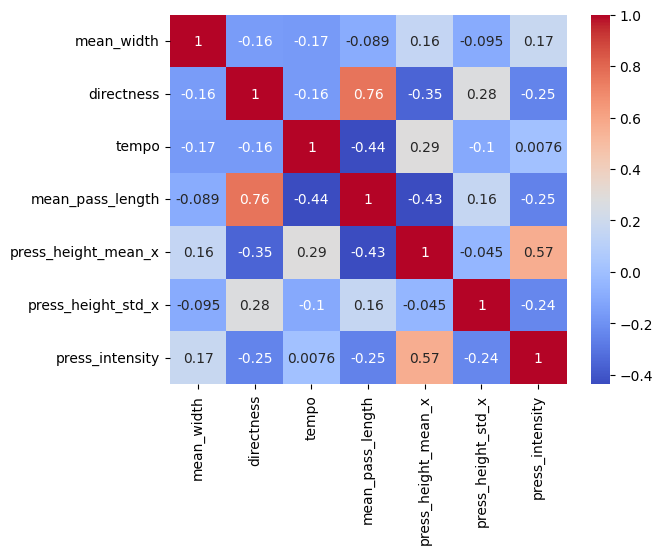

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.show()

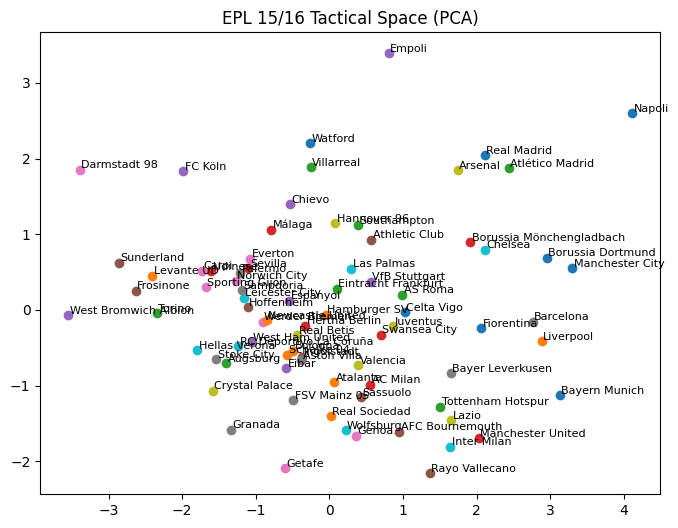

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for i, team in enumerate(team_season_z["team_name"]):
    plt.scatter(X_2d[i,0], X_2d[i,1])
    plt.text(X_2d[i,0]+0.02, X_2d[i,1]+0.02, team, fontsize=8)

plt.title("EPL 15/16 Tactical Space (PCA)")
plt.show()
